In [1]:
!pip install transformers

     |████████████████████████████████| 2.1MB 9.0MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 901kB 45.3MB/s 


In [2]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn.functional as F

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import datetime
import random, re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))

    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
# Read the data
train = pd.read_csv('/content/drive/MyDrive/DL for NLP/Project/train.tsv',sep='\t')
train = train.rename(columns={'Label': 'pre-Label'})

valid = pd.read_csv('/content/drive/MyDrive/DL for NLP/Project/valid.tsv', sep='\t', names=['Id', 'Text', 'pre-Label'])

test = pd.read_csv('/content/drive/MyDrive/DL for NLP/Project/test.tsv',sep='\t', names=['Id', 'Text', 'pre-Label'])

train['Label'] = train['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)
valid['Label'] = valid['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)
test['Label'] = test['pre-Label'].apply(lambda x: 1 if x == 'INFORMATIVE' else 0)

train = train.drop('pre-Label', axis = 1)
test = test.drop('pre-Label', axis = 1)
valid = valid.drop('pre-Label', axis = 1)

pd.set_option('display.max_colwidth', 150)


print(train.info())
print(valid.info())
print(test.info())
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6936 entries, 0 to 6935
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6936 non-null   int64 
 1   Text    6936 non-null   object
 2   Label   6936 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      1000 non-null   int64 
 1   Text    1000 non-null   object
 2   Label   1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      2000 non-null   int64 
 1   Text    2000 non-null   object
 2   Label   2000 non-null   int64 
dtypes: int64(2), object(1)
me

,Id,Text,Label
0,1241490299215634434,Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden...,1
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus deaths in the US in 24 hours (?) Covid19 pandemic is an international crime from China - not a natur...",1
2,1241132432402849793,"Latest Updates March 20 ⚠️5274 new cases and 38 new deaths in the United States Illinois: Governo Pritzker issues ""stay at home"" order for all res...",1
3,1236107253666607104,"真把公主不当干部 BREAKING: 21 people on Grand Princess cruise ship docked off the California coast tested positive for coronavirus, including 19 crew memb...",1
4,1239673817552879619,OKLAHOMA CITY — The State Department of Education announced Monday the closure of all K-12 public schools statewide until at least April 6 as the ...,0


In [6]:
valid.head()

,Id,Text,Label
0,1241728922192142336,"For those saying Pakistan isn’t Italy; After 3 weeks of the first confirmed case, Pakistan has a higher #Coronavirus growth rate than Italy. Exper...",0
1,1235713405992030209,"Second case DR 🇩🇴 The Canadian woman has not been identified, however they indicated that she is 70 years old and that she was staying with her hu...",1
2,1245941302367305728,Kill Chain: the cyber war on America's elections is a MUST SEE documentary for everyone who uses computers. HTTPURL As of 4/3/20 @USER @USER will ...,0
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting via @USER This technology was implemented due to #socialdistancing orders and FL EO 20-69 allowing ...,0
4,1240543259299987457,Report suggested that the actual number of undiagnosed Coronavirus positive cases in the country may be five 20 times than the official figure at ...,0


In [7]:
test.head()

,Id,Text,Label
0,1235770448966754309,"@USER PA hospitals don’t have the capacity. Latest from our local hospital is they will only test those with symptoms who returned from China, Ita...",0
1,1235748200742416384,Coronavirus outbreak: Intel employee in Bengaluru may be discharged today. Follow LIVE updates here: HTTPURL,1
2,1236129620363100161,Trump is trying to BS his way through the coronavirus outbreak. ⁦@USER brings together good evidence and comparisons here that suggest Trump is mo...,0
3,1241191765195001857,@USER How dramatically could we slow down this #Coronavirus from spreading if literally every american wore a mask for 2-3 weeks? I think it would...,0
4,1245182515213676546,"An Instagram post from comedienne Amy Schumer showed noisemaking and applause coming from buildings at around 7 pm, which is when shift changes oc...",0


In [8]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(valid.shape[0]))
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 6,936

Number of validation sentences: 1,000

Number of test sentences: 2,000



In [9]:
import string

def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

# df["text"] = df["text"].apply(lambda x: remove_url(x))
    
def remove_emoji(text):
  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" #emoticons
                               u"\U0001F300-\U0001F5FF" #symbols&pics
                               u"\U0001F680-\U0001F6FF" #transportation pic
                               u"\U0001F1E0-\U0001F1FF" #flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"    
                               "]+", flags = re.UNICODE)
  return emoji_pattern.sub(r'', text)

# df["text"] = df["text"].apply(lambda x: remove_emoji(x))

def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# df["text"] = df["text"].apply(lambda x: remove_punctuation(x))


def clean_text(text):
    
    text = text.lower() #lowercase
    
    text = re.sub(r'[!]+','!',text)
    text = re.sub(r'[?]+','?',text)
    #text = re.sub(r'[.]+','.',text)
    #text = re.sub(r"'","",text)
    #text = re.sub('\s+', '', text).strip() # Remove and double spaces
    #text = re.sub(r'&amp;?',r'and', text) # replace & -> and
    #text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # Remove URLs
    remove_url(text)
    remove_emoji(text)
    #text = re.sub(r'["$%\*\+,-\/:;<=>@\\^_`{|}~]+','',text) #remove some puncts (except . ! # ? &)
    
    return text


In [10]:
train['Text'] = train['Text'].apply(lambda x: clean_text(x))
valid['Text'] = valid['Text'].apply(lambda x: clean_text(x))
test['Text'] = test['Text'].apply(lambda x: clean_text(x))

train.head()

,Id,Text,Label
0,1241490299215634434,official death toll from #covid19 in the united kingdom is now greater than: germany + poland + switzerland + austria + portugal + greece + sweden...,1
1,1245916400981381130,"dearest mr. president @user 1,169 coronavirus deaths in the us in 24 hours (?) covid19 pandemic is an international crime from china - not a natur...",1
2,1241132432402849793,"latest updates march 20 ⚠️5274 new cases and 38 new deaths in the united states illinois: governo pritzker issues ""stay at home"" order for all res...",1
3,1236107253666607104,"真把公主不当干部 breaking: 21 people on grand princess cruise ship docked off the california coast tested positive for coronavirus, including 19 crew memb...",1
4,1239673817552879619,oklahoma city — the state department of education announced monday the closure of all k-12 public schools statewide until at least april 6 as the ...,0


In [11]:
valid.head()

,Id,Text,Label
0,1241728922192142336,"for those saying pakistan isn’t italy; after 3 weeks of the first confirmed case, pakistan has a higher #coronavirus growth rate than italy. exper...",0
1,1235713405992030209,"second case dr 🇩🇴 the canadian woman has not been identified, however they indicated that she is 70 years old and that she was staying with her hu...",1
2,1245941302367305728,kill chain: the cyber war on america's elections is a must see documentary for everyone who uses computers. httpurl as of 4/3/20 @user @user will ...,0
3,1245913002840391681,town hosts first #virtual #towncouncil meeting via @user this technology was implemented due to #socialdistancing orders and fl eo 20-69 allowing ...,0
4,1240543259299987457,report suggested that the actual number of undiagnosed coronavirus positive cases in the country may be five 20 times than the official figure at ...,0


In [12]:
test.head()

,Id,Text,Label
0,1235770448966754309,"@user pa hospitals don’t have the capacity. latest from our local hospital is they will only test those with symptoms who returned from china, ita...",0
1,1235748200742416384,coronavirus outbreak: intel employee in bengaluru may be discharged today. follow live updates here: httpurl,1
2,1236129620363100161,trump is trying to bs his way through the coronavirus outbreak. ⁦@user brings together good evidence and comparisons here that suggest trump is mo...,0
3,1241191765195001857,@user how dramatically could we slow down this #coronavirus from spreading if literally every american wore a mask for 2-3 weeks? i think it would...,0
4,1245182515213676546,"an instagram post from comedienne amy schumer showed noisemaking and applause coming from buildings at around 7 pm, which is when shift changes oc...",0


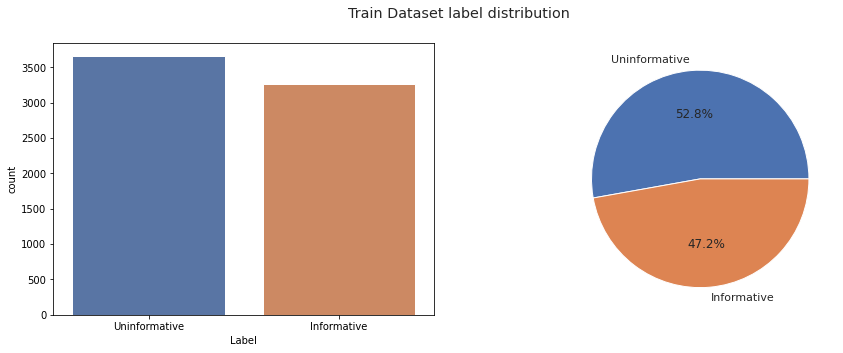

Number of uninformative (0) and informative (1) tweets contained in the train dataset:
0    3663
1    3273
Name: Label, dtype: int64


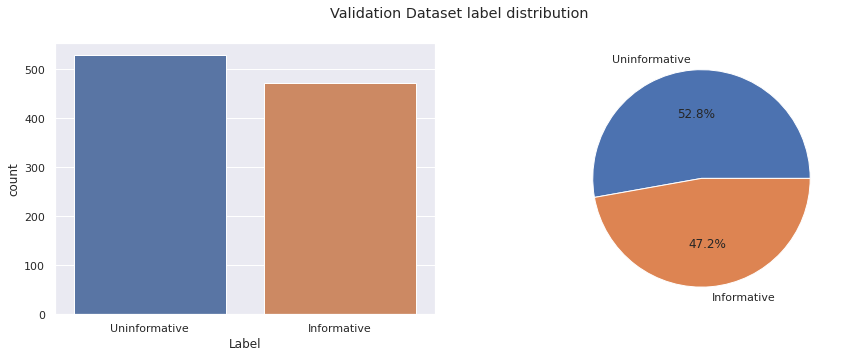

Number of uninformative (0) and informative (1) tweets contained in the validation dataset:
0    528
1    472
Name: Label, dtype: int64


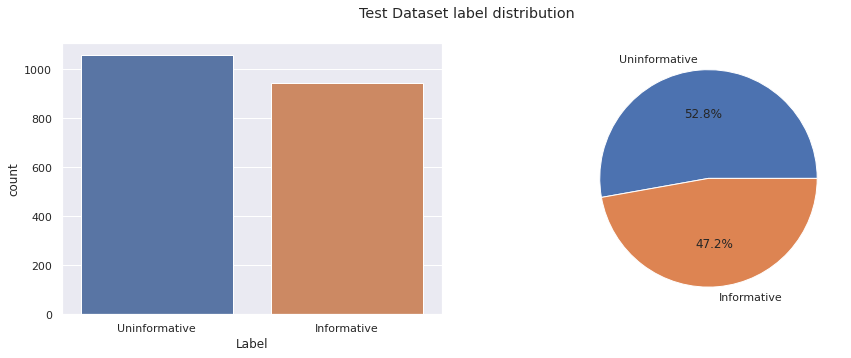

Number of uninformative (0) and informative (1) tweets contained in the test dataset:
0    1056
1     944
Name: Label, dtype: int64


In [13]:
# Plot count of informative and uninformative tweets in the train set

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
terms = ['Uninformative', 'Informative']
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Label", data=train, label = terms)
ax.set_xticklabels(terms)
weightage = [len(train[train['Label'] == 0]),len(train[train['Label'] == 1])]
plt.subplot(1, 2, 2)
plt.pie(weightage,labels=terms, autopct="%1.1f%%")
plt.suptitle("Train Dataset label distribution")
plt.show()

print('Number of uninformative (0) and informative (1) tweets contained in the train dataset:')
print(train['Label'].value_counts())


plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
terms = ['Uninformative', 'Informative']
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Label", data=valid, label = terms)
ax.set_xticklabels(terms)
weightage = [len(valid[valid['Label'] == 0]),len(valid[valid['Label'] == 1])]
plt.subplot(1, 2, 2)
plt.pie(weightage,labels=terms, autopct="%1.1f%%")
plt.suptitle("Validation Dataset label distribution")
plt.show()

print('Number of uninformative (0) and informative (1) tweets contained in the validation dataset:')
print(valid['Label'].value_counts())


plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
terms = ['Uninformative', 'Informative']
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Label", data=test, label = terms)
ax.set_xticklabels(terms)
weightage = [len(test[test['Label'] == 0]),len(test[test['Label'] == 1])]
plt.subplot(1, 2, 2)
plt.pie(weightage,labels=terms, autopct="%1.1f%%")
plt.suptitle("Test Dataset label distribution")
plt.show()

print('Number of uninformative (0) and informative (1) tweets contained in the test dataset:')
print(test['Label'].value_counts())


In [14]:
# Get the lists of sentences and their labels.
train_sentences_initial = train.Text.values
#train_labels_initial = train.Label.values

valid_sentences_initial = valid.Text.values
#valid_labels_initial = valid.Label.values

test_sentences_initial = test.Text.values
#test_labels_initial = test.Label.values

# Load the BERT tokenizer.
#To feed our text to BERT, it must be split into tokens, and then these tokens must be 
#mapped to their index in the tokenizer vocabulary.
#The tokenization must be performed by the tokenizer included with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [15]:
# Print the original sentence.
print('train Original: ', train_sentences_initial[0])
print('valid Original: ', valid_sentences_initial[0])
print('test Original: ', test_sentences_initial[0])

# Print the sentence split into tokens.
print('Tokenized train: ', tokenizer.tokenize(train_sentences_initial[0]))
print('Tokenized valid: ', tokenizer.tokenize(valid_sentences_initial[0]))
print('Tokenized test: ', tokenizer.tokenize(test_sentences_initial[0]))

# Print the sentence mapped to token ids.
print('train Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences_initial[0])))
print('valid Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(valid_sentences_initial[0])))
print('test Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_sentences_initial[0])))

train Original:  official death toll from #covid19 in the united kingdom is now greater than: germany + poland + switzerland + austria + portugal + greece + sweden + finland + norway + ireland... combined. uk: 67.5 million (233 dead) above group: 185 million (230 dead) httpurl
valid Original:  for those saying pakistan isn’t italy; after 3 weeks of the first confirmed case, pakistan has a higher #coronavirus growth rate than italy. experts on the issue say italy was too slow to lockdown. even after lockdown, it took time for it to properly have an impact. #corona
test Original:  @user pa hospitals don’t have the capacity. latest from our local hospital is they will only test those with symptoms who returned from china, italy, iran, japan , or south korea in last 14 days or those who have been in contact with someone with confirmed covid-19 in the last 14 days.
Tokenized train:  ['official', 'death', 'toll', 'from', '#', 'co', '##vid', '##19', 'in', 'the', 'united', 'kingdom', 'is', 'no

In [16]:
train_max_len = 0
valid_max_len = 0
test_max_len = 0

train_length_ls = []
valid_length_ls = []
test_length_ls = []

# Decide on a constant maximum sentence length for padding / truncating to 
# by choosing the max length of the sentences in the dataset.
for sent in train_sentences_initial:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  train_length_ls.append(len(input_ids))

  # Update the maximum sentence length.
  # train_max_len = max(train_max_len, len(input_ids))

for sent in valid_sentences_initial:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  valid_length_ls.append(len(input_ids))

  # Update the maximum sentence length.
  # valid_max_len = max(valid_max_len, len(input_ids))

for sent in test_sentences_initial:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  test_length_ls.append(len(input_ids))

  # Update the maximum sentence length.
  # test_max_len = max(test_max_len, len(input_ids))


train_length_df = pd.DataFrame(train_length_ls, columns = ['length'])
valid_length_df = pd.DataFrame(valid_length_ls, columns = ['length'])
test_length_df = pd.DataFrame(test_length_ls, columns = ['length'])

train_max_len = max(train_length_ls)
valid_max_len = max(valid_length_ls)
test_max_len = max(test_length_ls)

print('train dataset length: ', len(train_length_ls))
print('validation dataset length: ', len(valid_length_ls))
print('test dataset length: ', len(test_length_ls))
print()


print('train max sentence length: ', train_max_len)
print('valid max sentence length: ', valid_max_len)
print('test max sentence length: ', test_max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1104 > 512). Running this sequence through the model will result in indexing errors


train dataset length:  6936
validation dataset length:  1000
test dataset length:  2000

train max sentence length:  1461
valid max sentence length:  99
test max sentence length:  114


In [17]:
train_length_ls.sort()
valid_length_ls.sort()
test_length_ls.sort()

print('longest 5 train:', train_length_ls[len(train_length_ls) - 5:])
print('longest 5 valid:', valid_length_ls[len(valid_length_ls) - 5:])
print('longest 5 test:', test_length_ls[len(test_length_ls) - 5:])

longest 5 train: [141, 645, 1104, 1208, 1461]
longest 5 valid: [91, 91, 92, 96, 99]
longest 5 test: [90, 91, 101, 107, 114]


In [18]:
train_length_df['Label'] = train['Label']
valid_length_df['Label'] = valid['Label']
test_length_df['Label'] = test['Label']

print(train_length_df)
print(valid_length_df)
print(test_length_df)

      length  Label
0         65      1
1         66      1
2         68      1
3         58      1
4         48      0
...      ...    ...
6931      58      0
6932      39      1
6933      60      0
6934      56      0
6935      40      0

[6936 rows x 2 columns]
     length  Label
0        63      0
1        58      1
2        66      0
3        50      0
4        60      0
..      ...    ...
995      32      0
996      58      1
997      33      0
998      57      0
999      56      1

[1000 rows x 2 columns]
      length  Label
0         65      0
1         24      1
2         45      0
3         70      0
4         42      0
...      ...    ...
1995      56      0
1996      39      0
1997      56      1
1998      70      1
1999      41      1

[2000 rows x 2 columns]


In [19]:
drop_indices = train_length_df[train_length_df['length'].isin(train_length_ls[len(train_length_ls) - 4:])].index

train_length_df.drop(drop_indices, inplace = True)

train_length_df

,length,Label
0,65,1
1,66,1
2,68,1
3,58,1
4,48,0
...,...,...
6931,58,0
6932,39,1
6933,60,0
6934,56,0


In [20]:
# comparison of length of tweets between uninformative and informative ones, after removing 4 outlier from training dataset
import plotly.graph_objects as go

train_box_plot = [go.Box(y=train_length_df[train_length_df['Label']==0]['length'],name='Uninformative'),
        go.Box(y=train_length_df[train_length_df['Label']==1]['length'],name='Informative')]
layout = go.Layout(title = 'Comparison of text length in training dataset Tweets')
fig = go.Figure(data=train_box_plot, layout=layout)
fig.show()

valid_box_plot = [go.Box(y=valid_length_df[valid_length_df['Label']==0]['length'],name='Uninformative'),
        go.Box(y=valid_length_df[valid_length_df['Label']==1]['length'],name='Informative')]
layout = go.Layout(title = 'Comparison of text length in validation dataset Tweets')
fig = go.Figure(data=valid_box_plot, layout=layout)
fig.show()

test_box_plot = [go.Box(y=test_length_df[test_length_df['Label']==0]['length'],name='Uninformative'),
        go.Box(y=test_length_df[test_length_df['Label']==1]['length'],name='Informative')]
layout = go.Layout(title = 'Comparison of text length in test dataset Tweets')
fig = go.Figure(data=test_box_plot, layout=layout)
fig.show()

In [21]:
# display plot of sentence lengths after removing 4 outliers form training data set 

from plotly import graph_objs as go

train_text_length = train_length_df['length'].value_counts().sort_index()
valid_text_length = valid_length_df['length'].value_counts().sort_index()
test_text_length = test_length_df['length'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=train_text_length.index,
    y=train_text_length.values,
    name='train sent lengths',
    fill='tozeroy',
    marker_color="cyan",
))
fig.add_trace(go.Scatter(
    x=valid_text_length.index,
    y=valid_text_length.values,
    name='validation sent lengths',
    fill='tozeroy',
    marker_color="darkblue",
))
fig.add_trace(go.Scatter(
    x=test_text_length.index,
    y=test_text_length.values,
    name='test sent lengths',
    fill='tozeroy',
    marker_color="chocolate",
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Sentence Lengths</span>',
    xaxis_title = "Sentence length",
    yaxis_title = "Frequency"
)

fig.update_xaxes(range=[0, 150])
fig.show()

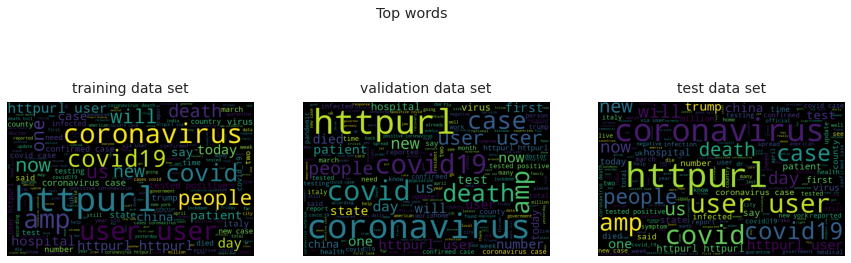

In [22]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#twitter_mask = np.array(Image.open('/content/drive/MyDrive/DL for NLP/Project/twitter_mask.jpg'))

# wc = WordCloud(
#    background_color='blue', 
#    max_words=200, 
#    mask=twitter_mask,
#)

wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110) 

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.title('training data set', 
          fontdict={'size': 14,  'verticalalignment': 'bottom'})
wc.generate(' '.join(text for text in train['Text']))
plt.imshow(wc)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title('validation data set', 
          fontdict={'size': 14,  'verticalalignment': 'bottom'})
wc.generate(' '.join(text for text in valid['Text']))
plt.imshow(wc)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title('test data set', 
          fontdict={'size': 14,  'verticalalignment': 'bottom'})
wc.generate(' '.join(text for text in test['Text']))
plt.imshow(wc)
plt.axis("off")
plt.suptitle('Top words')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


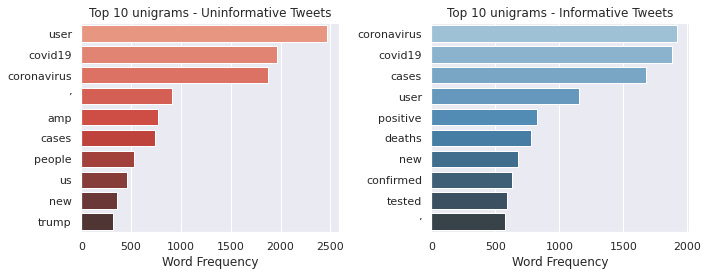

In [23]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from collections import Counter

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

train_unigrams = pd.DataFrame()
train_unigrams = train[['Text', 'Label']]
train_unigrams['Text_no_punc'] = train_unigrams['Text'].apply(lambda x: remove_punctuation(x))

stop_words = set(stopwords.words('english'))
stop_words.add('httpurl')

tokens = pd.DataFrame()
tokens['tokenized_minus_stop'] = train_unigrams['Text_no_punc'].apply(lambda x: [tokens.lower() for tokens in word_tokenize(x) if tokens.lower() not in stop_words])
tokens['Label'] = train_unigrams['Label']
token_list_ui = [j for i in tokens[tokens['Label'] == 0]['tokenized_minus_stop'] for j in i]
token_list_i = [j for i in tokens[tokens['Label'] == 1]['tokenized_minus_stop'] for j in i]

token_counts_ui = Counter(token_list_ui)
top_token_counts_ui = token_counts_ui.most_common(10)
top_token_counts_ui =sorted(top_token_counts_ui, key = lambda x: x[1], reverse=True)

token_counts_i = Counter(token_list_i)
top_token_counts_i = token_counts_i.most_common(10)
top_token_counts_i =sorted(top_token_counts_i, key = lambda x: x[1], reverse=True)

x_uninformative, y_uninformative = map(list, zip(*top_token_counts_ui))
x_informative, y_informative = map(list, zip(*top_token_counts_i))


fig_unigram, ax_unigram = plt.subplots(1,2, figsize=(10,4))
sns.barplot(x=y_uninformative, y=x_uninformative, orient='h', palette="Reds_d", ax=ax_unigram[0])
sns.barplot(x=y_informative, y=x_informative, orient='h', palette="Blues_d", ax=ax_unigram[1])


ax_unigram[0].set_title("Top 10 unigrams - Uninformative Tweets")
ax_unigram[0].set_xlabel("Word Frequency")
ax_unigram[1].set_title("Top 10 unigrams - Informative Tweets")
ax_unigram[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()



In [24]:

train.drop(drop_indices, inplace = True)

train_sentences = train.Text.values
train_labels = train.Label.values

valid_sentences = valid.Text.values
valid_labels = valid.Label.values

test_sentences = test.Text.values
test_labels = test.Label.values



In [25]:
train_max_len_v2 = 0
valid_max_len_v2 = 0
test_max_len_v2 = 0

train_length_ls_v2 = []
valid_length_ls_v2 = []
test_length_ls_v2 = []

# Decide on a constant maximum sentence length for padding / truncating to 
# by choosing the max length of the sentences in the dataset.
for sent in train_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  train_length_ls_v2.append(len(input_ids))

  # Update the maximum sentence length.
  # train_max_len = max(train_max_len, len(input_ids))

for sent in valid_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  valid_length_ls_v2.append(len(input_ids))

  # Update the maximum sentence length.
  # valid_max_len = max(valid_max_len, len(input_ids))

for sent in test_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)
  test_length_ls_v2.append(len(input_ids))

  # Update the maximum sentence length.
  # test_max_len = max(test_max_len, len(input_ids))

train_max_len_v2 = max(train_length_ls_v2)
valid_max_len_v2 = max(valid_length_ls_v2)
test_max_len_v2 = max(test_length_ls_v2)

print('train dataset length: ', len(train_length_ls_v2))
print('validation dataset length: ', len(valid_length_ls_v2))
print('test dataset length: ', len(test_length_ls_v2))
print()

print('train max sentence length: ', train_max_len_v2)
print('valid max sentence length: ', valid_max_len_v2)
print('test max sentence length: ', test_max_len_v2)

train dataset length:  6932
validation dataset length:  1000
test dataset length:  2000

train max sentence length:  141
valid max sentence length:  99
test max sentence length:  114


In [26]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []
valid_input_ids = []
valid_attention_masks = []

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])


# For every sentence...
for sent in valid_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    valid_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    valid_attention_masks.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)

valid_input_ids = torch.cat(valid_input_ids, dim=0)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

# Print sentence 0, now as a list of IDs.
print('train Original sentence: ', train_sentences[0])
print('train Token IDs list:', train_input_ids[0])

print('validation Original sentence: ', valid_sentences[0])
print('validation Token IDs list:', valid_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



train Original sentence:  official death toll from #covid19 in the united kingdom is now greater than: germany + poland + switzerland + austria + portugal + greece + sweden + finland + norway + ireland... combined. uk: 67.5 million (233 dead) above group: 185 million (230 dead) httpurl
train Token IDs list: tensor([  101,  2880,  2331,  9565,  2013,  1001,  2522, 17258, 16147,  1999,
         1996,  2142,  2983,  2003,  2085,  3618,  2084,  1024,  2762,  1009,
         3735,  1009,  5288,  1009,  5118,  1009,  5978,  1009,  5483,  1009,
         4701,  1009,  6435,  1009,  5120,  1009,  3163,  1012,  1012,  1012,
         4117,  1012,  2866,  1024,  6163,  1012,  1019,  2454,  1006, 22115,
         2757,  1007,  2682,  2177,  1024, 15376,  2454,  1006, 11816,  2757,
         1007,  8299,  3126,   102])
validation Original sentence:  for those saying pakistan isn’t italy; after 3 weeks of the first confirmed case, pakistan has a higher #coronavirus growth rate than italy. experts on the

In [27]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

In [28]:
# Define a batch size value for the DataLoader
# It is not recommended to use a high value, usually batch size of 16 or 32 works perfectly
batch_size = 32

# Create the DataLoaders for train set with the training samples in random order
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size 
        )

# For validation the order doesn't really matter, 
# so DataLoader will just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [29]:
# Load BertForSequenceClassification from_pretrained()
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # Number of output labels--2 for binary classification (1 and 0).
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
# Initialize the AdamW optimizer 

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

# Number of training epochs.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [31]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# I will use this function to know how much time the model needed to train
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, 
                             return_dict=False)


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        #print(type(loss))
        #print(loss)

        total_train_loss += loss.item()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, I'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took  {:} time".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:09.
  Batch    80  of    217.    Elapsed: 0:00:17.
  Batch   120  of    217.    Elapsed: 0:00:26.
  Batch   160  of    217.    Elapsed: 0:00:35.
  Batch   200  of    217.    Elapsed: 0:00:43.

  Average training loss: 0.27
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.43
  Validation took  0:00:02 time

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:09.
  Batch    80  of    217.    Elapsed: 0:00:17.
  Batch   120  of    217.    Elapsed: 0:00:26.
  Batch   160  of    217.    Elapsed: 0:00:34.
  Batch   200  of    217.    Elapsed: 0:00:43.

  Average training loss: 0.10
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.36
  Validation took  0:00:02 time

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:09.
  Batch    80  of    217.    Elapsed: 

In [33]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_statistics = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_statistics = df_statistics.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_statistics

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.27,0.43,0.87,0:00:47,0:00:02
2,0.10,0.36,0.89,0:00:46,0:00:02
3,0.05,0.45,0.89,0:00:46,0:00:02
4,0.02,0.57,0.89,0:00:46,0:00:02


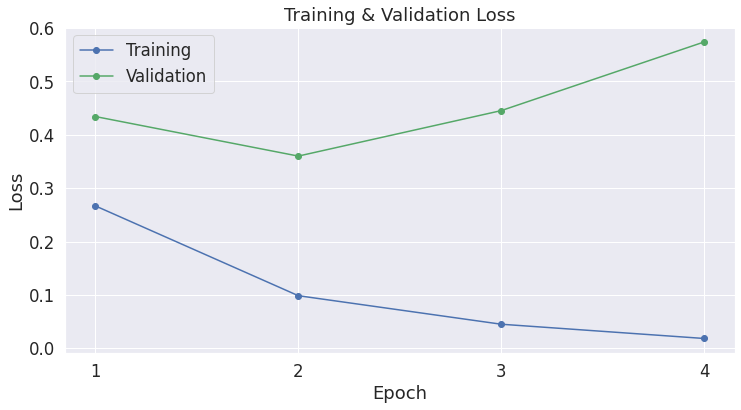

In [34]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_statistics['Training Loss'], 'b-o', label="Training")
plt.plot(df_statistics['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [35]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

test_labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('test Original sentence: ', test_sentences[0])
print('test Token IDs list:', test_input_ids[0])

Number of test sentences: 2,000



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



test Original sentence:  @user pa hospitals don’t have the capacity. latest from our local hospital is they will only test those with symptoms who returned from china, italy, iran, japan , or south korea in last 14 days or those who have been in contact with someone with confirmed covid-19 in the last 14 days.
test Token IDs list: tensor([  101,  1030,  5310,  6643,  8323,  2123,  1521,  1056,  2031,  1996,
         3977,  1012,  6745,  2013,  2256,  2334,  2902,  2003,  2027,  2097,
         2069,  3231,  2216,  2007,  8030,  2040,  2513,  2013,  2859,  1010,
         3304,  1010,  4238,  1010,  2900,  1010,  2030,  2148,  4420,  1999,
         2197,  2403,  2420,  2030,  2216,  2040,  2031,  2042,  1999,  3967,
         2007,  2619,  2007,  4484,  2522, 17258,  1011,  2539,  1999,  1996,
         2197,  2403,  2420,   102])


In [36]:
# Set test_data_set, the batch size and create DataLoader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 32 # same as in training: 32  

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [37]:
    print("")
    print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

    test_stats = []

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, I'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_test_accuracy = total_eval_accuracy / len(test_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_eval_loss / len(test_dataloader)
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.2f}".format(avg_test_loss))
    print("  Test took  {:} time".format(test_time))

    # Record all statistics from this epoch.
    test_stats.append(
        {
            'Test. Loss': avg_val_loss,
            'Test. Accur.': avg_val_accuracy,
            'Test time': test_time
        }
    )


Predicting labels for 2,000 test sentences...
  Accuracy: 0.87
  Test Loss: 0.64
  Test took  0:00:04 time
